# BLACK BOX CLASSIFIER AND DATASET

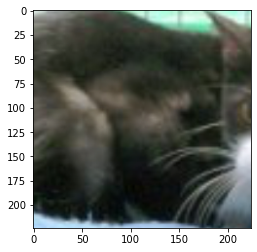

True Class: Cat Predicted Class: Cat


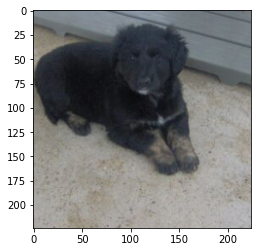

In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np

#set path to your stuff bro
blackbox_classifier_weight_path = r"C:\Users\JOCL\Desktop\Andet\10 Semester\Advanced_Machine_Learning\Projects\Explainability\code\LIME\blackboxclassifier_weights\CatVsDog_weights"
image_dir = r"C:\Users\JOCL\Desktop\Andet\10 Semester\Advanced_Machine_Learning\Projects\Explainability\code\LIME\predict"

#functions
def imshow(img):
    inv_normalize = transforms.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225])
    img = inv_normalize(img)
    img = torch.squeeze(img)
    npimg = 255 * img.numpy()
    npimg = npimg.astype('uint8')
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()


# load model architecture (same used for training on Cat VS Dog dataset)
model = models.densenet121(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.classifier = nn.Sequential(nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

#load model weights from black box training (Train loss: 0.109.. Test loss: 0.031.. Test accuracy: 0.988)
model.load_state_dict(torch.load(blackbox_classifier_weight_path))
model.eval()

#predicition on image example
predict_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

pred_data = datasets.ImageFolder(image_dir, transform=predict_transforms)
predloader = torch.utils.data.DataLoader(pred_data, batch_size=1, shuffle=True)
preds_to_check = 1
i = 0                  
classes = ["Cat", "Dog"]

for img, class_idx in predloader:
    if i == preds_to_check:
        break
    imshow(img)
    model_out = model(img)
    model_out = F.softmax(model_out, dim = 1)
    pred = torch.max(model_out, dim = 1).indices
    
    
    i += 1
    print(f"True Class: {classes[class_idx]} Predicted Class: {classes[pred]}")
    


# LIME Algorithm

In [2]:
#code from https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb
#and modified 



##


def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    


pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()


def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()






In [4]:
batch_predict(img.numpy())

RuntimeError: The size of tensor a (224) must match the size of tensor b (3) at non-singleton dimension 0